In [199]:
# importing necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### preparing necessary classes

In [203]:
# defining current dataset so we can input any current to our model
class CurrentDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[idx].values
        return torch.tensor(sample)

In [204]:
#defining LIF class
class LIF(torch.nn.Module):
    def __init__(self, R, tau, u_rest, threshold):
        super(LIF, self).__init__()
        self.R = R
        self.tau = tau
        self.u = u_rest
        self.u_rest = u_rest
        self.threshold = threshold
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
    
    def forward(self, x):
        dt = x[0] - self.time
        self.time = x[0]
        
        # calculating du from the equation du = dt * (-(u - u_rest) + RI(t)) / tau
        du = dt * (-1 * (self.u-self.u_rest) + self.R * x[1]) / self.tau
        self.u += du
        
        #checking if u reached the threshold
        if self.u > self.threshold:
            self.to_rest()
            self.history = torch.vstack((self.history,torch.tensor([self.time, self.u])))
            return torch.tensor([[self.time, 1]])
        else : 
            self.history = torch.vstack((self.history,torch.tensor([self.time, self.u])))
            return torch.tensor([[self.time, 0]])
    
    #reseting the model
    def reset(self):
        self.u = self.u_rest
        self.time = 0
        self.history = torch.tensor([self.time, self.u])
        
    # when u reaches the threshold it needs to be back to rest potential
    def to_rest(self):
        self.u = self.u_rest

In [224]:
#filtering current data that would lead to spikes:
def process(model, currents):
    spikes_data = None 
    for data in currents:
        result = model(data[0])
        if spikes_data is None:
            spikes_data = result
        else : 
            spikes_data = torch.vstack((spikes_data, result))
    return spikes_data

### plotting functions

In [200]:
def plot_currents(df_1, df_2, df_):
    plt.figure(figsize=(8, 3))
    df_1['current'].plot(label='current_1', color='orange')
    df_2['current'].plot(label='current_2', color='b')
    df_3['current'].plot(label='current_3', color='g')
    plt.title('Currents')

    plt.xlabel('time')
    plt.ylabel('I(t)')

    plt.legend()

In [201]:
def plot_spikes(spikes):
    spike_points = spikes[spikes[:,1]==1.0]
    fig = plt.figure(figsize=(8, 3))
    plt.scatter(spike_points[:,0],spike_points[:,1],marker='|',c='r',s=500)
    plt.xlabel("time (mS)")
    plt.yticks(ticks=[1],labels=['spike'])
    plt.grid()
    plt.title("Spike points diagram")
    plt.show()

In [202]:
def plot_history(history):
    fig = plt.figure(figsize=(8,3))
    plt.plot(history[:,0],history[:,1],c='g')
    plt.xlabel("time (mS)")
    plt.ylabel("Voltage(mV)")
    plt.grid()
    plt.title("PSP diagram")
    plt.show()

In [ ]:
### Initializing LIF model with arbitrary values for given parameters

In [206]:
R = 0.1 
tau = 80
u_rest = -65
threshold = -50

lif = LIF(R, tau, u_rest, threshold)

## Part a and b :

### creating 3 current datasets

In [207]:
time_steps = 1000
current_1 = np.ones(time_steps)
time = np.linspace(0, time_steps, time_steps, endpoint=False)
df_1 = pd.DataFrame({'time': pd.Series(time)})
current_1[0:100] = 0
current_1[100:1000] = 200
df_1['current'] = current_1

df_2 = pd.DataFrame({'time': pd.Series(time)})
current_2 = np.ones(time_steps)
current_2[0:200] = 0
current_2[200:1000] = 300
df_2['current'] = current_2

current_3 = np.ones(time_steps)
df_3 = pd.DataFrame({'time': pd.Series(time)})
current_3[0:300] = 0
current_3[300:1000] = 400
df_3['current'] = current_3

plotting them

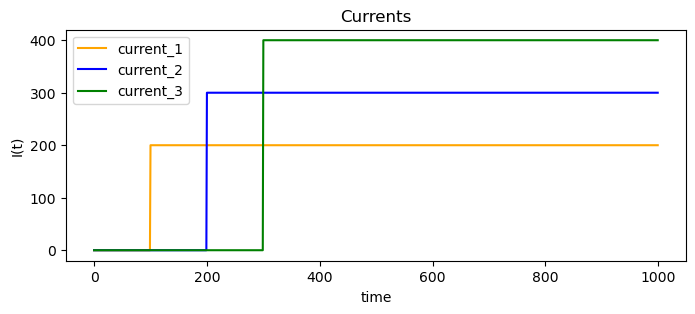

In [208]:
plot_currents(df_1, df_2, df_3)

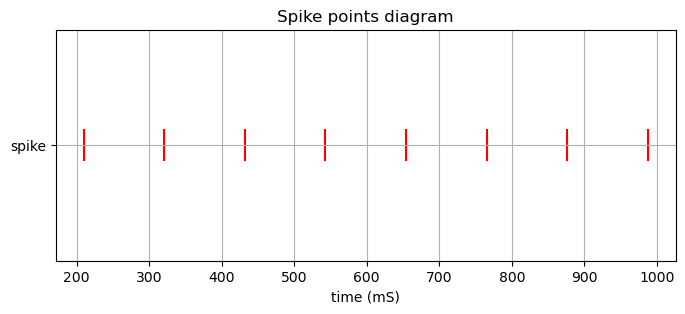

In [209]:
dataset_1 = CurrentDataset(df_1)
dataloader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=1, shuffle=False)

spikes_1 = process(lif, dataloader_1)
plot_spikes(spikes_1)

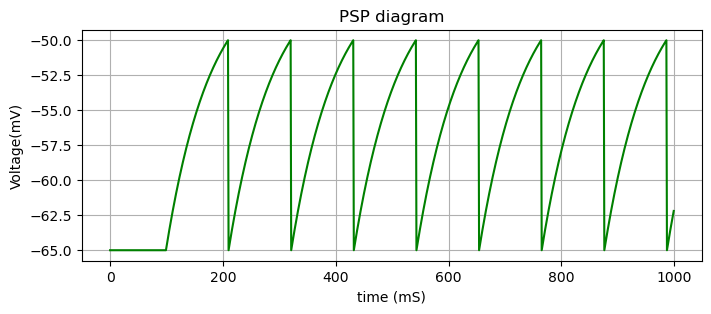

In [210]:
plot_history(lif.history)

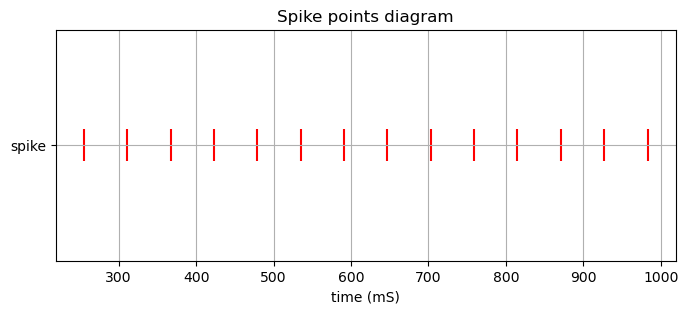

In [211]:
lif.reset()
dataset_2 = CurrentDataset(df_2)
dataloader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=1, shuffle=False)

spikes_2 = process(lif, dataloader_2)
plot_spikes(spikes_2)

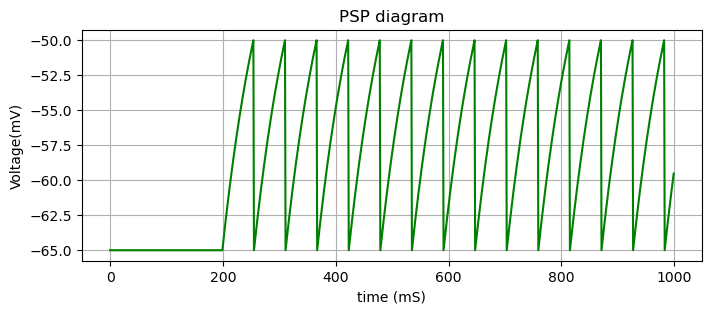

In [212]:
plot_history(lif.history)

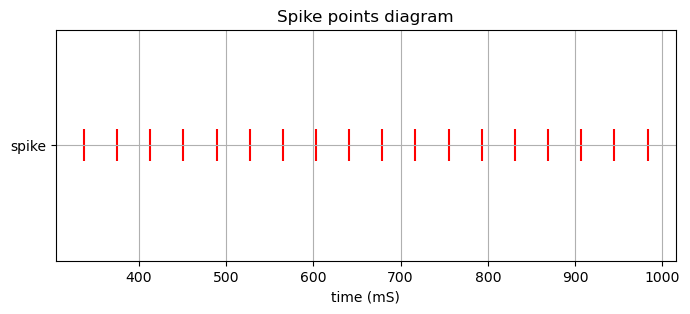

In [213]:
lif.reset()
dataset_3 = CurrentDataset(df_3)
dataloader_3 = torch.utils.data.DataLoader(dataset_3, batch_size=1, shuffle=False)
spikes_3 = process(lif, dataloader_3)
plot_spikes(spikes_3)

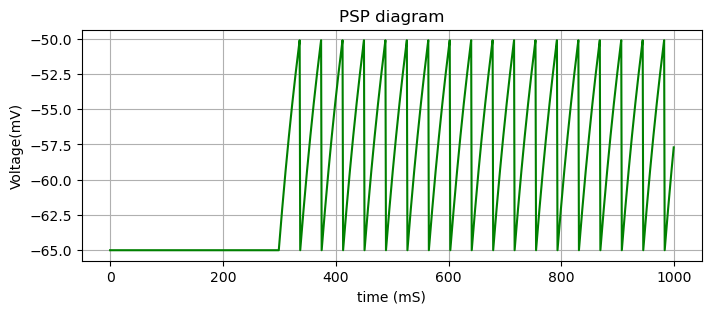

In [214]:
plot_history(lif.history)

In [217]:
lif.reset()
rand = pd.read_csv('random_current.csv')
rand = rand[:1000]

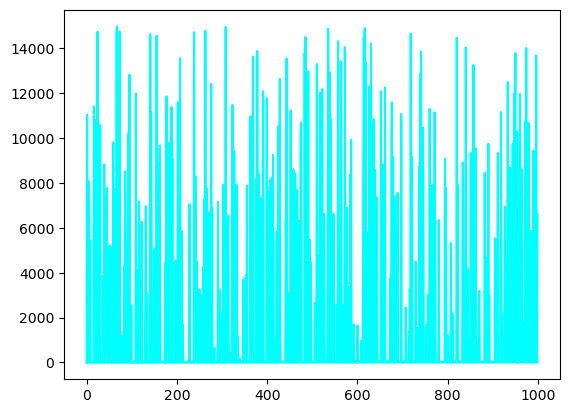

In [223]:
plt.plot(rand, color='aqua')

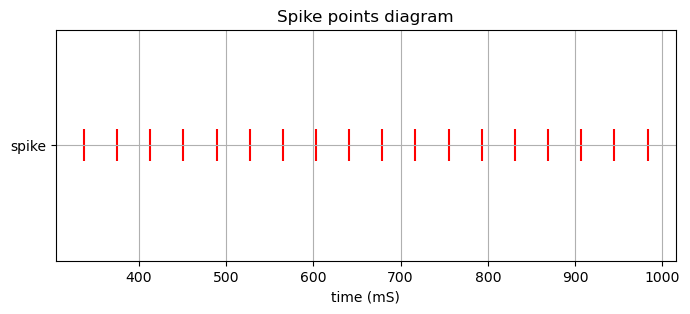

In [221]:
dataset = CurrentDataset(rand)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
spikes = process(lif, dataloader)
plot_spikes(spikes_3)

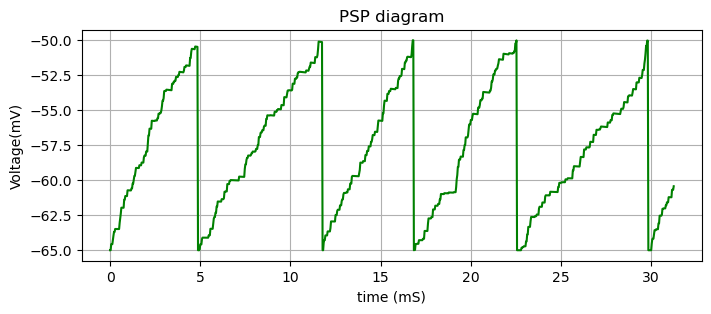

In [222]:
plot_history(lif.history)